# data preprocess

In [1]:
# if you want to downland and extract dataset and timm, uncomment the following lines
# !wget https://www.di.ens.fr/willow/teaching/recvis18orig/assignment3/bird_dataset.zip
# #     "/content/bird_dataset.zip"
# import zipfile
# with zipfile.ZipFile("bird_dataset.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content")
# !pip install timm

## Import library, dataset 

In [16]:
import zipfile
import os
import timm
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import argparse
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.autograd import Variable
from tqdm.notebook import tqdm
import torchvision
import pandas as pd
import copy
import matplotlib.pyplot as plt
import sklearn
from timm.data.mixup import Mixup
from torchvision.transforms import InterpolationMode
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import NuSVC   
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

def normalize(x):
    x_c=x-x.mean(-1).view(-1,1)
    x_norm=x_c/torch.norm(x_c, p='fro',dim=-1).view(-1,1)
    return x_norm
    

use_cuda = torch.cuda.is_available()
torch.manual_seed(42)

# Create experiment folder
if not os.path.isdir("experiment"):
    os.makedirs("experiment")

# Data initialization and loading
# from data import data_transforms

im_size=224
bs=16
data_transforms1 = transforms.Compose([
    transforms.Resize((im_size, im_size)),
#     transforms.CenterCrop(im_size),
        

    transforms.ToTensor(),
#     transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder("/content/bird_dataset" + '/train_images',
                         transform=data_transforms1),
    batch_size=bs, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder("/content/bird_dataset" + '/val_images',
                         transform=data_transforms1),
    batch_size=bs, shuffle=False, num_workers=1)


# generel testing loop

In [5]:
class Model(nn.Module):
    def __init__(self,feature_extractor,dim_encoder,lr=1e-2,weight_decay=0.,last_layer=None,train_loader=train_loader,val_loader=val_loader):
        super(Model, self).__init__()

        self.feature_extractor =  feature_extractor
        self.dim_encoder = dim_encoder
        if last_layer!=None:
            self.fc1=last_layer
        else:
            self.fc1 = nn.Linear(self.dim_encoder, 20)
        self.train_loader=train_loader
        self.val_loader = val_loader
        self.test_loss=[]
        # self.super_test=False
        self.n_augment = 10
        self.optimizer = torch.optim.SGD(self.parameters(),lr=lr,momentum=0.9,weight_decay=weight_decay) 
        #optim.AdamW(self.parameters(), lr=lr,weight_decay=weight_decay)
        # self.augment= transforms.AutoAugment(
        # policy = transforms.AutoAugmentPolicy.IMAGENET, 
        # interpolation = transforms.InterpolationMode.BILINEAR,)
        # 
        self.grad_accu=True
        self.accum_iter=3
        # for mixup
        self.mixup=True
        self.mixup_args = {
            'mixup_alpha': 1.,
            'cutmix_alpha': 0.,
            'cutmix_minmax': None,
            'prob': 0.5,
            'switch_prob': 0.,
            'mode': 'batch',
            'label_smoothing': 0.0,
            'num_classes': 20}
        self.mixup_fn = Mixup(**self.mixup_args)
        
        self.mixed_precision=False # for speed up but not used here


    def forward(self, x):
        with torch.no_grad():
          x = self.feature_extractor(x)
        x = x.reshape(x.size(0),-1)
        x = self.fc1(x)
        return x

    def train_model(self, epoch,trainloader=None,print_=True):
        """ train loop for one epoch"""
        if trainloader==None:
            trainloader=self.train_loader
        else:
            trainloader=train_loader
        self.train()
        correct=0
#         if self.mixed_precision:
#             mixed=torch.float16
#         else:
#             mixed= torch.float32
#         with torch.autocast(device_type='cuda', dtype=mixed):
        if True: # for speed up replace by the above line

            for batch_idx, (data, target) in enumerate(train_loader):
                self.optimizer.zero_grad()

                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                hard_target=target
                if self.mixup:
                    data, target=self.mixup_fn(data, target)
                output = self(data)
                criterion = torch.nn.CrossEntropyLoss(reduction='mean')
                loss = criterion(output, target)
                loss.backward()
            # weights update
                if self.grad_accu:
                    if ((batch_idx + 1) % self.accum_iter == 0) or (batch_idx + 1 == len(train_loader)):
                        self.optimizer.step()
                        self.optimizer.zero_grad()
#                         self.scaler.step(self.optimizer)
#                         self.scaler.update()
#                         self.optimizer.zero_grad()
                else:
#                     self.scaler.step(self.optimizer)
#                     self.scaler.update()
#                     self.optimizer.zero_grad()
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(hard_target.data.view_as(pred)).cpu().sum()
                # if batch_idx % 20 == 0:
            if print_:
                print('Train Epoch: {}, accuracy:{:.5f} \tLoss: {:.6f}'.format(
                    epoch, 100. * correct / len(trainloader.dataset) ,loss.data.item()))

    def test_model(self,valloader=None,print_=True):
            """test loop for one epoch"""
#         with torch.autocast(device_type='cuda', dtype=torch.float16):

            if valloader==None:
                valloader=self.val_loader
            else:
                valloader=valloader
            self.eval()
            validation_loss = 0
            correct = 0
            count=0
            for data, target in val_loader:
                count=1
                data_aug =data

                data_aug, target = data_aug.cuda(), target.cuda()
                output = (self(data_aug)+ self(transforms.functional.hflip(data_aug)))/2


                criterion = torch.nn.CrossEntropyLoss(reduction='mean')
                validation_loss += criterion(output, target).data.item()
                # get the index of the max log-probability
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            validation_loss /= len(valloader.dataset)
            if print_:
                print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                    validation_loss, correct, len(valloader.dataset),
                    100. * correct / len(valloader.dataset)))
            self.test_loss.append(100. * correct / len(valloader.dataset))

        
    def test_mod(self,val_loader):
        self.eval()
        
        validation_loss = 0
        correct = 0
        count=0
        for data, target in val_loader:
            count=1
            data_aug =data
            
            data_aug, target = data_aug.cuda(), target.cuda()
            output = self(data_aug)
            

            criterion = torch.nn.CrossEntropyLoss(reduction='mean')
            validation_loss += criterion(output, target).data.item()
            # get the index of the max log-probability
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        validation_loss /= len(val_loader.dataset)
        print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            validation_loss, correct, len(val_loader.dataset),
            100. * correct / len(val_loader.dataset)))
#         self.test_loss.append(100. * correct / len(val_loader.dataset))
        
        
    def fit(self,epochs,lr=1e-2,val_loader=None,print_=True):
      """fit model for n epochs"""
#       self.scaler = torch.cuda.amp.GradScaler()
        
      if print_:
            print_flag=True
      else: 
            print_flag=False
      for g in self.optimizer.param_groups:
          g['lr'] = lr
      max_v=0  
      for epoch in (range(1, epochs)):
        if epochs//2<epoch:
            for g in self.optimizer.param_groups:
                g['lr'] = lr/10
        self.train_model(epoch,print_=print_flag)
        with torch.no_grad():
            self.test_model(print_=print_flag)
        if val_loader!=None:
            self.test_mod(val_loader,print_=print_flag)
        if self.test_loss[-1]>max_v:
            max_v=self.test_loss[-1]
            self.last_layer=copy.deepcopy(self.fc1)
      return np.max(self.test_loss)


    def extract_feat(self,data_loader,aug=True,im_size=0):
        """extract features and targets from model for a given dataloader
        with augmentation"""
        with torch.no_grad():
            self.eval()
            # five=transforms.FiveCrop(self.feature_extractor.default_cfg["input_size"][-1]-offset)
            feat=torch.tensor([])
            all_feat=torch.tensor([])
            all_target= torch.tensor([])
            
            for data, target in tqdm(data_loader):
                feat=self.forward_aug(data.cuda(),im_size=im_size)
                for _ in range(2):
                  all_target=torch.cat((all_target,target),0)
                all_feat=torch.cat((all_feat,feat.cpu()),0)
                  
        return all_feat,all_target

    def forward_aug(self,x,mode="cat",im_size=0):
        """use data augmetation to extract features from model, 
        extract the feature for 10 crops of the same images and compute the centroid
        redo that for the flipped image to have twice the number of data
        im_size: size of the crop, if 0 use the default size of the model """

        with torch.no_grad():
            
            self.eval()
            if im_size!=0:
            
              ten=transforms.TenCrop(im_size)

            else:
                # define 10 crops transform
              ten=transforms.TenCrop(self.feature_extractor.default_cfg["input_size"][-1])
            flag=True
            count=0
            #flip the image
            x_flip = transforms.functional.hflip(x)
            #extract 10 crops from the flipped image 
            x_aug = ten(x_flip)
            #extract 10 crops from the original image
            x_aug2 = ten(x)
            #extract features for each crop
            for i in range(len(x_aug)):
                x_crop=x_aug[i].cuda()
                x_crop2=x_aug2[i].cuda()

                x_feat = self.feature_extractor(x_crop)
                x_feat2 = self.feature_extractor(x_crop2)
                x_feat = x_feat.reshape(x_flip.size(0),-1)
                x_feat2 = x_feat2.reshape(x_flip.size(0),-1)
                if flag:
                    feat1=x_feat.cpu()
                    feat2=x_feat2.cpu()
                    flag=False
                    count+=1
                else:
                    feat1+=x_feat.cpu()
                    feat2+=x_feat2.cpu()
                    count+=1
            feat1=feat1/count  
            feat2=feat2/count

                    
        return torch.cat((feat1,feat2))



# dataset

In [6]:
# /!\ change the path to the folder where you saved the dataset if needed

def return_dataset(im_size,bs=64):
    """create dataloader for a given image size and batch size"""
  
    bs=bs
    data_transforms_train_1 = transforms.Compose([
        transforms.Resize((im_size, im_size)),
    #     transforms.CenterCrop(im_size),

    #       transforms.TrivialAugmentWide(num_magnitude_bins=2),
    #     transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    #     transforms.ColorJitter(brightness=.5, hue=.3),
#         transforms.RandomRotation(degrees=(0, 180)),
    #     transforms.RandomPosterize(bits=2),
    #     transforms.RandomAdjustSharpness(sharpness_factor=2),

        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ])

    data_transforms1 = transforms.Compose([
        transforms.Resize((im_size, im_size)),
    #     transforms.CenterCrop(im_size),

    #       transforms.TrivialAugmentWide(),

        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ])

    trainset=datasets.ImageFolder("/content/bird_dataset" + '/train_images',  # /!\ change the path to the folder where you saved the dataset
                         transform=data_transforms_train_1)    
    train_loader = torch.utils.data.DataLoader(
        trainset,
        batch_size=bs, shuffle=True, num_workers=1)
    testset= datasets.ImageFolder("/content/bird_dataset" + '/val_images',  # /!\ change the path to the folder where you saved the dataset
                             transform=data_transforms1)
    val_loader = torch.utils.data.DataLoader(
        testset,
        batch_size=bs, shuffle=False, num_workers=1)
    return trainset,testset

In [7]:
# concatenate the two datasets

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
data=torch.utils.data.ConcatDataset((return_dataset(224)))
dataloaders = torch.utils.data.DataLoader(data, batch_size=32, shuffle=False)



# try some timm models 

In [21]:


all_mod=["swinv2_large_window12to24_192to384_22kft1k",  
    "swin_large_patch4_window7_224",
    "swin_base_patch4_window7_224_in22k", 
         "swin_base_patch4_window12_384_in22k",
         "swin_base_patch4_window12_384",
         "beitv2_base_patch16_224_in22k",
         "swin_large_patch4_window12_384_in22k",
         "swin_large_patch4_window12_384",
         "swinv2_base_window12to24_192to384_22kft1k",       
         "convnext_tiny_in22k",
         "convnext_small_in22k",
         "convnext_base_in22k",
         "convnext_tiny_384_in22ft1k",
         "convnext_small_384_in22ft1k",
         "convnext_base_384_in22ft1k",
         "convnext_large_384_in22ft1k",   
         "convnext_xlarge_384_in22ft1k",   
         "convnext_large_in22k",            
         "beitv2_large_patch16_224_in22k", 
         "beitv2_large_patch16_224_in22k",

]

#  ['resmlp_12_224_dino',
#  "resmlp_24_224_dino",
#  "vit_base_patch8_224_dino",
# "vit_base_patch16_224_dino",
# "vit_small_patch8_224_dino",
# "vit_small_patch16_224_dino"]

# all_mod=["convnext_xlarge_384_in22ft1k",
#       "convnext_large_384_in22ft1k",
#       "convnext_large_in22k",
#     "convnext_base_384_in22ft1k",
#          "convnext_small_384_in22ft1k",
#   "beitv2_base_patch16_224_in22k",
#              "beitv2_large_patch16_224_in22k", 
#          "swin_base_patch4_window12_384",
#          "swin_base_patch4_window7_224_in22k",
#          "swinv2_large_window12to24_192to384_22kft1k"
# ]

# all_mod=[
#     # "swin_large_patch4_window7_224",
#     # "swin_large_patch4_window12_384_in22k",
#     # "swin_large_patch4_window12_384",
#     # "swinv2_base_window12to24_192to384_22kft1k",
#     # "convnext_tiny_in22k",
#     "convnext_small_in22k",
#          "convnext_base_384_in22ft1k",
#          "convnext_tiny_384_in22ft1k"
# ]

In [9]:
# good model
# what I used for kaggle maybe overkill
all_mod=["beitv2_base_patch16_224_in22k",
         "convnext_base_384_in22ft1k",
         "swin_base_patch4_window12_384_in22k",
         "convnext_small_in22k"
         ]

# quick one for testing
all_mod=["convnext_small_in22k",
         "convnext_base_384_in22ft1k",
         "convnext_tiny_384_in22ft1k"]


all_m=[]
for model_name in tqdm(all_mod):
  m = timm.create_model(model_name, num_classes=0,pretrained=True).cuda()
  dim_encoder=m(torch.zeros((2,3,im_size,im_size)).cuda()).size(-1)
  all_m.append(Model(m,
              last_layer=nn.Sequential(nn.Linear(dim_encoder,20)),              
                   dim_encoder=dim_encoder,train_loader=train_loader,val_loader=val_loader).cuda())

  0%|          | 0/3 [00:00<?, ?it/s]

# transform data into features + test them with sklearn model

KNeighborsClassifier, LinearSVC, SVC,  NuSVC, RandomForestClassifier, GaussianNB, LinearDiscriminantAnalysis


In [17]:
X_all,y_all= [],[]
all_transf=[]
all_layer=[]
all_acc=[]
for model_name in tqdm(all_mod):
    print("========================================")
    print("===========>"+model_name)
    bs=32
    m = timm.create_model(model_name, num_classes=0,pretrained=True).cuda()
    im_size=m.default_cfg["input_size"][-1]
    offset=50
    data_transforms = transforms.Compose([
    transforms.Resize((im_size+offset, im_size+offset)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])
    all_transf.append(data_transforms)
    for dat in data.datasets:
        dat.transform=data_transforms
    dim_encoder=m(torch.zeros((2,3,im_size,im_size)).cuda()).size(-1)
    feature_extractor=m
    # dim_encoder=768
    model1 = Model(feature_extractor,
              last_layer=nn.Sequential(nn.Linear(dim_encoder,20)),              
                   dim_encoder=dim_encoder,train_loader=train_loader,val_loader=val_loader).cuda()
        
    X,y=model1.extract_feat(dataloaders)
    X_all.append(X)
    y_all.append(y)
    # X_test, y_test=model1.extract_feat(val_loader)
    skf = RepeatedStratifiedKFold(n_splits=6, n_repeats=1,
     random_state=42)#StratifiedKFold(n_splits=6)
    skf.get_n_splits(X,y=y)
    last_layer=[]

    print(skf)
    count=0
    acc_1=[]
    acc_2=[]
    acc_sk=[]

    for train_index, test_index in skf.split(X,y=y):
        count+=1
        # print("========================================\n")
        # print("split number "+str(count))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        proto=torch.zeros((20,dim_encoder))
        for i in range(20):
            proto[i]=X_train[y_train==i].mean(0)
        corr=0
        for i in range(len(X_test)):
            pred=torch.cdist(proto,X_test[i].view(1,-1)).argmin()
            if pred==y_test[i]:
                corr+=1
        # print(corr/len(X_test))
        acc_1.append(corr/len(X_test))
            


        X_train_c=normalize(X_train)
        X_test_c=normalize(X_test)
        proto=torch.zeros((20,dim_encoder))
        for i in range(20):
            proto[i]=X_train_c[y_train==i].mean(0)
        corr=0
        for i in range(len(X_test_c)):
            pred=torch.cdist(proto,X_test_c[i].view(1,-1)).argmin()
            if pred==y_test[i]:
                corr+=1
        # print(corr/len(X_test_c))
        acc_2.append(corr/len(X_test))

        classifiers = [
            KNeighborsClassifier(10),
            svm.LinearSVC(),
            SVC(kernel="rbf", probability=True),
            NuSVC(probability=True),
            RandomForestClassifier(),
            GaussianNB(),
            LinearDiscriminantAnalysis(),
            
            ]

        
        acc_=[]
        for clf in classifiers:
            clf.fit(X_train,y_train)      

            test_predictions = clf.predict(X_test)
            acc_s = accuracy_score(y_test, test_predictions)
            acc_.append(acc_s)
        acc_sk.append(acc_)
    print("acc_1 NMC")
    print(np.mean(acc_1),np.std(acc_1))
    print("acc_2 NMC normalized")
    print(np.mean(acc_2),np.std(acc_2))
    print("knn, svmlin, SVC   , nusvc,  rf, gnb,  lda")
    print("mean")
    print(np.mean(acc_sk,axis=0))
    print("std")
    print(np.std(acc_sk,axis=0))

  0%|          | 0/3 [00:00<?, ?it/s]

===========>convnext_small_in22k


  0%|          | 0/38 [00:00<?, ?it/s]

RepeatedStratifiedKFold(n_repeats=1, n_splits=6, random_state=42)


c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: Conv

acc_1 NMC
0.9358649789029535 0.012881297487319601
acc_2 NMC normalized
0.9341772151898734 0.012825893800481554
knn, svmlin, SVC   , nusvc,  rf, gnb,  lda
mean
[0.91814346 0.98227848 0.97004219 0.95864979 0.98565401 0.92194093
 0.97679325]
std
[0.01414604 0.01122712 0.00370252 0.00648198 0.00540348 0.00894077
 0.01117148]
===========>convnext_base_384_in22ft1k


  0%|          | 0/38 [00:00<?, ?it/s]

RepeatedStratifiedKFold(n_repeats=1, n_splits=6, random_state=42)


c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: Conv

acc_1 NMC
0.9358649789029535 0.015514579165274456
acc_2 NMC normalized
0.9350210970464135 0.015095817569618817
knn, svmlin, SVC   , nusvc,  rf, gnb,  lda
mean
[0.91223629 0.98902954 0.96582278 0.95780591 0.98481013 0.92953586
 0.98227848]
std
[0.01422135 0.01070766 0.00955675 0.01080696 0.00506329 0.00985031
 0.00759494]
===========>convnext_tiny_384_in22ft1k


  0%|          | 0/38 [00:00<?, ?it/s]

RepeatedStratifiedKFold(n_repeats=1, n_splits=6, random_state=42)


c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\lejuj\Anaconda3\envs\hippo\lib\site-packages\sklearn\svm\_base.py:1225: Conv

acc_1 NMC
0.9265822784810127 0.013943216575407846
acc_2 NMC normalized
0.9261603375527426 0.013508700922854106
knn, svmlin, SVC   , nusvc,  rf, gnb,  lda
mean
[0.91772152 0.98312236 0.96962025 0.95443038 0.98396624 0.92109705
 0.98312236]
std
[0.01599485 0.00954743 0.00901019 0.01825596 0.00897059 0.01412715
 0.00648198]


In [279]:
X_all,y_all= [],[]
all_transf=[]
all_layer=[]
all_acc=[]
for model_name in tqdm(all_mod):
    print("========================================")
    print("===========>"+model_name)
    bs=32
    m = timm.create_model(model_name, num_classes=0,pretrained=True).cuda()
    im_size=m.default_cfg["input_size"][-1]
    offset=50
    data_transforms = transforms.Compose([
    transforms.Resize((im_size+offset, im_size+offset)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])
    all_transf.append(data_transforms)
    for dat in data.datasets:
        dat.transform=data_transforms
    dim_encoder=m(torch.zeros((2,3,im_size,im_size)).cuda()).size(-1)
    feature_extractor=m
    # dim_encoder=768
    model1 = Model(feature_extractor,
              last_layer=nn.Sequential(nn.Linear(dim_encoder,20)),              
                   dim_encoder=dim_encoder,train_loader=train_loader,val_loader=val_loader).cuda()
        
    X,y=model1.extract_feat(dataloaders)
    X_all.append(X)
    y_all.append(y)
    # X_test, y_test=model1.extract_feat(val_loader)
    skf = RepeatedStratifiedKFold(n_splits=6, n_repeats=1,
     random_state=42)#StratifiedKFold(n_splits=6)
    skf.get_n_splits(X,y=y)
    last_layer=[]

    print(skf)
    count=0
    acc_1=[]
    acc_2=[]
    acc_sk=[]

    for train_index, test_index in skf.split(X,y=y):
        count+=1
        # print("========================================\n")
        # print("split number "+str(count))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        proto=torch.zeros((20,dim_encoder))
        for i in range(20):
            proto[i]=X_train[y_train==i].mean(0)
        corr=0
        for i in range(len(X_test)):
            pred=torch.cdist(proto,X_test[i].view(1,-1)).argmin()
            if pred==y_test[i]:
                corr+=1
        # print(corr/len(X_test))
        acc_1.append(corr/len(X_test))
            


        X_train_c=normalize(X_train)
        X_test_c=normalize(X_test)
        proto=torch.zeros((20,dim_encoder))
        for i in range(20):
            proto[i]=X_train_c[y_train==i].mean(0)
        corr=0
        for i in range(len(X_test_c)):
            pred=torch.cdist(proto,X_test_c[i].view(1,-1)).argmin()
            if pred==y_test[i]:
                corr+=1
        # print(corr/len(X_test_c))
        acc_2.append(corr/len(X_test))

        classifiers = [
            KNeighborsClassifier(10),
            svm.LinearSVC(),
            SVC(kernel="rbf", probability=True),
            NuSVC(probability=True),
            RandomForestClassifier(),
            GaussianNB(),
            LinearDiscriminantAnalysis(),
            
            ]

        
        acc_=[]
        for clf in classifiers:
            clf.fit(X_train,y_train)      

            test_predictions = clf.predict(X_test)
            acc_s = accuracy_score(y_test, test_predictions)
            acc_.append(acc_s)
        acc_sk.append(acc_)
    print("acc_1 NMC")
    print(np.mean(acc_1),np.std(acc_1))
    print("acc_2 NMC normalized")
    print(np.mean(acc_2),np.std(acc_2))
    print("knn, svmlin, SVC   , nusvc,  rf, gnb,  lda")
    print("mean")
    print(np.mean(acc_sk,axis=0))
    print("std")
    print(np.std(acc_sk,axis=0))

  0%|          | 0/4 [00:00<?, ?it/s]

===========>beitv2_base_patch16_224_in22k


  0%|          | 0/38 [00:00<?, ?it/s]

RepeatedStratifiedKFold(n_repeats=1, n_splits=6, random_state=36851234)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

acc_1
0.9392405063291139 0.007594936708860769
acc_2
0.9388185654008439 0.005739017092293432
knn, svmlin, SVC   , nusvc,  rf, gnb,  lda
[0.92869198 0.98649789 0.97510549 0.95949367 0.98649789 0.93459916
 0.98481013]
[0.00792755 0.00754791 0.00995816 0.00924426 0.00477372 0.01302561
 0.00700981]
===========>convnext_base_384_in22ft1k


  0%|          | 0/38 [00:00<?, ?it/s]

RepeatedStratifiedKFold(n_repeats=1, n_splits=6, random_state=36851234)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

acc_1
0.9388185654008439 0.013025611004584919
acc_2
0.9371308016877636 0.012177949105199816
knn, svmlin, SVC   , nusvc,  rf, gnb,  lda
[0.91434599 0.98902954 0.97257384 0.96075949 0.98649789 0.92995781
 0.97974684]
[0.0185702  0.00540348 0.00644065 0.01041263 0.00238686 0.01030089
 0.00826832]
===========>swin_base_patch4_window12_384_in22k


Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window12_384_22k.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window12_384_22k.pth


  0%|          | 0/38 [00:00<?, ?it/s]

RepeatedStratifiedKFold(n_repeats=1, n_splits=6, random_state=36851234)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

acc_1
0.9468354430379745 0.011415822159045309
acc_2
0.9476793248945147 0.010404074266614306
knn, svmlin, SVC   , nusvc,  rf, gnb,  lda
[0.93628692 0.9907173  0.98185654 0.96624473 0.98734177 0.93586498
 0.98481013]
[0.01117148 0.00680359 0.01277722 0.01429627 0.00759494 0.00695883
 0.00653668]
===========>convnext_small_in22k


  0%|          | 0/38 [00:00<?, ?it/s]

RepeatedStratifiedKFold(n_repeats=1, n_splits=6, random_state=36851234)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

acc_1
0.9345991561181434 0.0075124446475801025
acc_2
0.930801687763713 0.006315033564175423
knn, svmlin, SVC   , nusvc,  rf, gnb,  lda
[0.92278481 0.98987342 0.97257384 0.96329114 0.98902954 0.92447257
 0.98818565]
[0.00697161 0.00413416 0.00894077 0.01139241 0.00347941 0.01182188
 0.00578536]


# Overfitting sklearn class with CV on KFold

## grid search 

In [2]:
# l_max_acc=[]
# l_splits=np.arange(3,15,2)
# l_splits=[10]

# for split in tqdm(l_splits):

#   print("============>")

#   print("============>")
#   print(split)


#   parameters = {'kernel':('linear', 'rbf'), 'C':[0.1,0.2,0.3],"degree":[1,2]}
#   svc = svm.SVC()
#   skf = RepeatedStratifiedKFold(n_splits=split, n_repeats=3,
#       random_state=42)
#   clf1 = GridSearchCV(svc, parameters,verbose=1,return_train_score=True,cv=skf)
#   clf1.fit(X, y)
#   # GridSearchCV(estimator=SVC(),
#   #              param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

#   print(clf1.best_params_)
#   res2 = clf1.cv_results_

#   train_score1 = res1['mean_train_score']
#   test_score1 = res1['mean_test_score']
#   print(train_score1,test_score1)
#   print(np.max(test_score1))
#   l_max_acc.append(np.max(test_score1))


In [3]:

# l_max_acc_sv=[]
# l_splits=np.arange(3,12,2)
# l_splits=[10]
# for split in tqdm(l_splits):

#   print("============>")

#   print("============>")
#   print(split)

#   parameters = {"penalty":("l1", "l2"), "loss":("hinge", "squared_hinge"),'C':[0.1,0.2]}
#   svclin = svm.LinearSVC()
#   skf = RepeatedStratifiedKFold(n_splits=split, n_repeats=4,
#       random_state=42)
#   clf2 = GridSearchCV(svclin, parameters,verbose=1,return_train_score=True,cv=skf)
#   clf2.fit(X, y)

#   print(clf2.best_params_)
#   res = clf2.cv_results_

#   train_score = res['mean_train_score']
#   test_score = np.nan_to_num(res['mean_test_score'])
#   print(train_score,test_score)
#   print(np.max(np.nan_to_num(test_score)))
#   l_max_acc_sv.append(np.max(np.nan_to_num(test_score)))
  


In [163]:
# skf = RepeatedStratifiedKFold(n_splits=8, n_repeats=2,
#     random_state=42)
# svclin = svm.LinearSVC(C=1.,loss="squared_hinge",penalty="l2")
# cv_=cross_val_score(svclin, X, y, cv=skf)
# cv_=sklearn.model_selection.cross_validate(svclin, X, y, cv=skf,return_estimator=True)
# cv_

{'fit_time': array([0.91793489, 0.90261602, 0.93145204, 0.896029  , 0.90431762,
        0.92800593, 0.90639257, 0.9477272 , 0.93827391, 0.92716241,
        0.94411612, 0.90766048, 0.93428779, 0.92179728, 0.9496398 ,
        0.93871737]),
 'score_time': array([0.00197053, 0.00228906, 0.0018537 , 0.00180054, 0.00193691,
        0.00184989, 0.00182557, 0.00189281, 0.002038  , 0.00184512,
        0.00185943, 0.00214124, 0.00181127, 0.00186157, 0.00182605,
        0.00228333]),
 'estimator': [LinearSVC(),
  LinearSVC(),
  LinearSVC(),
  LinearSVC(),
  LinearSVC(),
  LinearSVC(),
  LinearSVC(),
  LinearSVC(),
  LinearSVC(),
  LinearSVC(),
  LinearSVC(),
  LinearSVC(),
  LinearSVC(),
  LinearSVC(),
  LinearSVC(),
  LinearSVC()],
 'test_score': array([0.95973154, 0.92567568, 0.93243243, 0.94594595, 0.9527027 ,
        0.96621622, 0.94594595, 0.93918919, 0.94630872, 0.95945946,
        0.97297297, 0.95945946, 0.91891892, 0.92567568, 0.93243243,
        0.96621622])}

In [162]:
# #clf2["estimator"],
# cv_["test_score"]

array([0.96644295, 0.93243243, 0.93243243, 0.93243243, 0.9527027 ,
       0.96621622, 0.94594595, 0.93918919, 0.94630872, 0.95945946,
       0.97297297, 0.96621622, 0.91891892, 0.92567568, 0.93243243,
       0.96621622])

## concat extract dataset from all model along the features dim

In [19]:
X_cat=torch.tensor([])
y_cat=torch.tensor([])

for i in range(len(X_all)):
    X_cat=torch.cat((X_cat,X_all[i]),dim=-1)
y_cat=y_all[0]
print(X_cat.size())

torch.Size([2370, 2560])


# Train PCA+LDA and report

size of features >> size of trainset 
(1) reduce numbers of features with unsupervised dimension reduction with PCA to n_components 
(2) train a classifier after dimensional reduction here I used LinearDiscriminantAnalysis other thing should work

In [296]:
all_mod

['beitv2_base_patch16_224_in22k',
 'convnext_base_384_in22ft1k',
 'swin_base_patch4_window12_384_in22k',
 'convnext_small_in22k']

In [413]:
from numpy.random.mtrand import logistic
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
preproc=[]
lda = LinearDiscriminantAnalysis()
# logistic=LogisticRegression()
# scaler = StandardScaler()
pca = PCA()

pipe = Pipeline(steps=[("pca",pca),("lda", lda)#, ("logistic", logistic)
])



param_grid = {
  "pca__n_components": [10,30,42],
  # "logistic__C": np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid,cv=10)
search.fit(X_cat, y_cat)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
preproc.append(search.best_estimator_)


search.cv_results_

Best parameter (CV score=0.942):
{'pca__n_components': 42}


{'mean_fit_time': array([0.29044597, 0.37313616, 0.39025106]),
 'std_fit_time': array([0.12870603, 0.00969218, 0.01305501]),
 'mean_score_time': array([0.00654764, 0.00699151, 0.00695019]),
 'std_score_time': array([2.01348595e-03, 6.21261710e-04, 4.89614249e-05]),
 'param_pca__n_components': masked_array(data=[10, 30, 42],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'pca__n_components': 10},
  {'pca__n_components': 30},
  {'pca__n_components': 42}],
 'split0_test_score': array([0.907173  , 0.92827004, 0.93670886]),
 'split1_test_score': array([0.90295359, 0.94936709, 0.95780591]),
 'split2_test_score': array([0.91139241, 0.94092827, 0.94514768]),
 'split3_test_score': array([0.89451477, 0.93670886, 0.94514768]),
 'split4_test_score': array([0.92405063, 0.93248945, 0.94514768]),
 'split5_test_score': array([0.89873418, 0.95780591, 0.9535865 ]),
 'split6_test_score': array([0.87763713, 0.93248945, 0.93670886]),
 'split7_test

In [34]:
from numpy.random.mtrand import logistic
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
preproc=[]
lda = LinearDiscriminantAnalysis()
# logistic=LogisticRegression()
# scaler = StandardScaler()
pca = PCA()

pipe = Pipeline(steps=[("pca",pca),("lda", lda)#, ("logistic", logistic)
])

all_componenets = [10,30,42,100,500,1000]

param_grid = {
  "pca__n_components": all_componenets,
  # "logistic__C": np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid,cv=10)
search.fit(X_cat, y_cat)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
preproc.append(search.best_estimator_)


search.cv_results_

Best parameter (CV score=0.989):
{'pca__n_components': 1000}


{'mean_fit_time': array([0.15805304, 0.28259974, 0.39629967, 1.40150046, 5.17470677,
        9.19135764]),
 'std_fit_time': array([0.00917524, 0.03840895, 0.03497155, 0.11081463, 0.31390566,
        0.5899171 ]),
 'mean_score_time': array([0.00730076, 0.00840123, 0.00720055, 0.00979912, 0.01699376,
        0.02809768]),
 'std_score_time': array([0.00078037, 0.00363846, 0.00087131, 0.00116437, 0.00173591,
        0.00230122]),
 'param_pca__n_components': masked_array(data=[10, 30, 42, 100, 500, 1000],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'pca__n_components': 10},
  {'pca__n_components': 30},
  {'pca__n_components': 42},
  {'pca__n_components': 100},
  {'pca__n_components': 500},
  {'pca__n_components': 1000}],
 'split0_test_score': array([0.89873418, 0.93248945, 0.94514768, 0.95780591, 0.97890295,
        0.99156118]),
 'split1_test_score': array([0.91139241, 0.94092827, 0.9535865 , 0.9535865 , 0.

Text(0, 0.5, 'cross validation Accuracy')

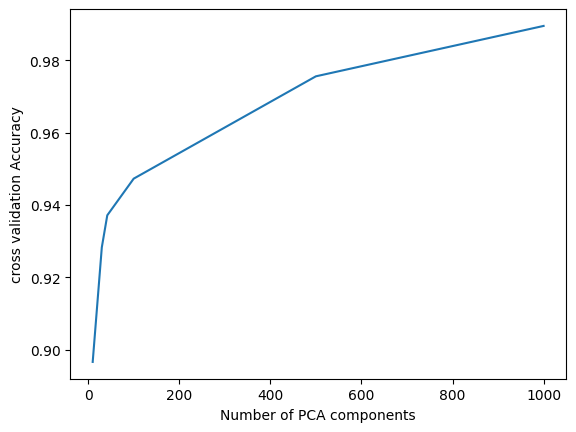

In [35]:
plt.plot(all_componenets,search.cv_results_["mean_test_score"])
plt.xlabel("Number of PCA components")
plt.ylabel("cross validation Accuracy")

Text(0, 0.5, 'explained_variance_')

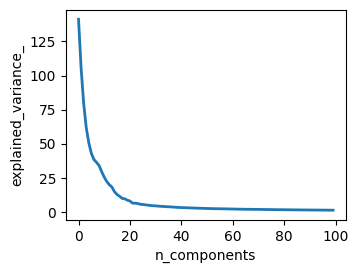

In [24]:
from sklearn.decomposition import PCA
pca = PCA()

# plot pca explained variance
pca.fit(X_cat)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_[:100], linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')


# create csv file for kaggle submission 

In [505]:

import argparse
from tqdm import tqdm
import os
import PIL.Image as Image


# use_cuda = torch.cuda.is_available()



test_dir = "/content/bird_dataset" + '/test_images/mistery_category'

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

outfile="kaggleensemble_lda_pcareg_ens_rec.csv"
output_file = open(outfile, "w")
output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):

    if 'jpg' in f:
        image=pil_loader(test_dir + '/' + f)
        output=torch.tensor([])
        for n_mod in range(len(all_m)):
          data = all_transf[n_mod](image)
          data = data.view(1, data.size(0), data.size(1), data.size(2))
          data = data.cuda()
          output = torch.cat((output,all_m[n_mod].forward_aug(data).cpu().detach()),dim=1)
        pred= search.best_estimator_.predict_proba(output)[0]
        pred=pred.argmax()
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle competition website')

100%|██████████| 517/517 [11:48<00:00,  1.37s/it]

Succesfully wrote kaggleensemble_lda_pcareg_ens_rec.csv, you can upload this file to the kaggle competition website
